# Section2：LSTM

### RNNの課題
- 時系列を遡れば遡るほど、勾配が消失していく。 \
　⇒　長い時系列の学習が困難。


- 解決策
前回の授業で触れた勾配消失の解決方法とは別で、構造自体を変えて解決したものがLSTM。

#### 勾配爆発とは？
勾配が、層を逆伝播するごとに指数関数的に大きくなっていく。


## 2.1 CEC
勾配消失および勾配爆発の解決方法として、勾配が、1であれば解決できる。

\begin{aligned}
  \delta^{t-z-1} &= \delta^{t-z} 
  \left\{
    Wf(u^{t-z-1}) 
  \right\}  = 1 \\
    \frac{\partial E}{\partial C^{t-1}} 
    &= \frac{\partial E}{\partial C^t}  \frac{\partial C^t}{\partial C^{t-1}}
    = \frac{\partial E}{\partial C^t}  \frac{\partial}{\partial C^{t-1}} \{ a^t-C^{t-1} \}
    = \frac{\partial E}{\partial C^t}
\end{aligned}

- CECの課題 \
入力データについて、時間依存度に関係なく重みが一律である。 \
　⇒　ニューラルネットワークの学習特性が無いということ。

## 2.2 入力ゲートと出力ゲート

- 入力・出力ゲートの役割とは？ \
入力・出力ゲートを追加することで、それぞれのゲートへの入力値の重みを、重み行列W,Uで可変可能とする。 \
⇒CECの課題を解決。

## 2.3 忘却ゲート

- LSTMの現状 \
CECは、過去の情報が全て保管されている。
- 課題 \
過去の情報が要らなくなった場合、削除することはできず、保管され続ける。
- 解決策 \
過去の情報が要らなくなった場合、そのタイミングで情報を忘却する機能が必要。

## 2.4 覗き穴結合

- 課題 \
CECの保存されている過去の情報を、任意のタイミングで他のノードに伝播させたり、あるいは任意のタイミングで忘却させたい。 \
CEC自身の値は、ゲート制御に影響を与えていない。

覗き穴結合とは？ \
　⇒　CEC自身の値に、重み行列を介して伝播可能にした構造。

#### ゼロから作るディープラーニング② 6.2 勾配消失とLSTM
RNNの学習においては、勾配消失も大きな問題です。そして、それを解決するにはRNNレイヤーのアーキテクチャを根本から変える必要があります。ここで登場するのが、「ゲート付きRNN」です。このゲート付きRNNには多くのアーキテクチャが提案されており、、その代表格にLSTMとGRUがあります。

#### ゼロから作るディープラーニング② 6.2.3 ｆOutputゲート
Outputゲートの開き具合（次へ何％通すか）は、入力$x_t$と前の状態$h_{t-1}$から求めます。

#### ゼロから作るディープラーニング② 6.4 LSTMを使った言語モデル

In [1]:
# coding: utf-8
import sys
sys.path.append('.')
import numpy as np
import time
import matplotlib.pyplot as plt
from common.util import eval_perplexity,clip_grads
from common.layers import *
from common.functions import softmax, sigmoid
from dataset import ptb
from rnnlm import Rnnlm

In [2]:
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [3]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


In [4]:
class SGD:
    '''
    確率的勾配降下法（Stochastic Gradient Descent）
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.61
| epoch 1 |  iter 261 / 1327 | time 49[s] | perplexity 713.72
| epoch 1 |  iter 521 / 1327 | time 98[s] | perplexity 346.72
| epoch 1 |  iter 781 / 1327 | time 148[s] | perplexity 261.65
| epoch 1 |  iter 1041 / 1327 | time 198[s] | perplexity 223.16
| epoch 1 |  iter 1301 / 1327 | time 248[s] | perplexity 186.78
| epoch 2 |  iter 1 / 1327 | time 253[s] | perplexity 213.89
| epoch 2 |  iter 261 / 1327 | time 302[s] | perplexity 178.54
| epoch 2 |  iter 521 / 1327 | time 352[s] | perplexity 163.87
| epoch 2 |  iter 781 / 1327 | time 395[s] | perplexity 151.95
| epoch 2 |  iter 1041 / 1327 | time 439[s] | perplexity 147.86
| epoch 2 |  iter 1301 / 1327 | time 482[s] | perplexity 128.46
| epoch 3 |  iter 1 / 1327 | time 486[s] | perplexity 154.29
| epoch 3 |  iter 261 / 1327 | time 530[s] | perplexity 132.12
| epoch 3 |  iter 521 / 1327 | time 573[s] | perplexity 125.03
| epoch 3 |  iter 781 / 1327 | time 616[s] | perplexity 119.

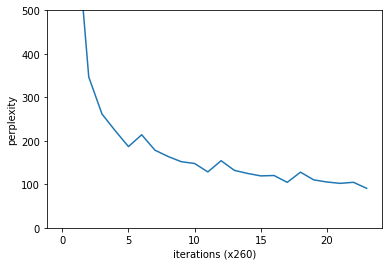

evaluating perplexity ...
234 / 235
test perplexity:  136.17995135851004


In [5]:
# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=260)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

# 確認テスト

#### P62
問） \
シグモイド関数を微分した時、入力値が0の時に最大値をとる。その値として正しいものを選択肢から選べ。
1. 0.15
1. 0.25
1. 0.35
1. 0.45

答） \
（２）0.25

Stage3 day2 Section1 P18の確認テストと同様のため、計算式を省略します。

#### P78
問） \
以下の文章をLSTMに入力し空欄に当てはまる単語を予測したいとする。 \
文中の「とても」という言葉は空欄の予測においてなくなっても影響を及ぼさないと考えられる。 \
このような場合、どのゲートが作用すると考えられるか。 

「映画おもしろかったね。ところで、とてもお腹が空いたから何か____。」

答） \
忘却ゲート